# Top contributors

There may be some value in comparing the speed and engagement in responding to and merging PRs between the top (10ish?) contributors and the median/mean contributors. This visualization is not fully fleshed out for the purpose of exploring some different ways of looking at this to determine if this is useful to look at and which fashion.

_Relevant issues:_ [#61](https://github.com/sandiego-rh/sandiego/issues/61)

note: https://www.zainrizvi.io/blog/jupyter-notebooks-best-practices-use-virtual-environments/ for setting up virtual environments in this RHODs JL instance. This notebook will aim to query the Augur DB to derive measurements specified in the GitHub Community Metrics working document: https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

**Imports and Database (Augur) connection**

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
import datetime
from pandas.tseries.offsets import BusinessDay
from matplotlib.ticker import MaxNLocator
from dateutil.relativedelta import relativedelta
plt.rcParams['figure.figsize'] = (17, 5)

warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], 
                                                                           config['password'], 
                                                                           config['host'], 
                                                                           config['port'], 
                                                                           config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters  

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In other words, this cell translates a repo's name (augur or grimoirelab) into their respective repo-id.

In [2]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ["augur"]
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440]


## Gather data

This measurement is derived from removing all non-unique and non-first entries of the same reporter_id. We are then able to track the timestamps in order of first-time issue submissions.
The resulting plot will show the aggregate number of issue-submitters vs. time.

**Query for repo's issues, ascending time**

In [3]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    i.reporter_id,
                    i.issue_id AS issue_id, 
                    i.pull_request_id,
                    i.gh_issue_number AS issue_number,
                    i.created_at AS created, 
                    i.closed_at AS closed,
                    irm.issue_msg_ref_id,
                    m.msg_timestamp AS msg_time,
                    m.msg_text AS comment_text,
                    m.cntrb_id AS msgr_id
                FROM
                    repo r,
                    issues i,
                    issue_message_ref irm, 
                    message m 
                WHERE
                    m.msg_id = irm.msg_id AND
                    irm.issue_id = i.issue_id AND
                    r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
                 ORDER BY
                    i.created_at                  
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)

## What is the distribution of contributors?

### By messages

In [4]:
df_issues['time_to_response'] = (df_issues["msg_time"] - df_issues["created"])
df_issues.head(3)

,reporter_id,issue_id,pull_request_id,issue_number,created,closed,issue_msg_ref_id,msg_time,comment_text,msgr_id,time_to_response
0,280508,340141,NaN,2,2017-01-20 15:04:01,2017-02-17 03:05:14,1201369,2017-01-24 20:49:40,"great, thanks! How should I make the config?",277697,4 days 05:45:39
1,280508,340141,NaN,2,2017-01-20 15:04:01,2017-02-17 03:05:14,1201373,2017-02-02 22:37:26,@GeorgLink the commands @abuhman mentioned are...,277693,13 days 07:33:25
2,280508,340141,NaN,2,2017-01-20 15:04:01,2017-02-17 03:05:14,1201374,2017-02-15 16:55:41,This issue is no longer relevant since we move...,277693,26 days 01:51:40


In [5]:
df_issues["time_to_response"] = df_issues["time_to_response"].astype('timedelta64[D]')

In [6]:
df_issues["time_to_response"].describe()

count    3463.000000
mean     -129.930696
std       241.321244
min      -835.000000
25%      -296.000000
50%         0.000000
75%         8.000000
max       616.000000
Name: time_to_response, dtype: float64

We see here that the time to response is oftentimes negative. This is a known bug for data collection, tracked in an [issue here](https://github.com/chaoss/augur/issues/1510). For now, we will filter out and evaluate the values greater than 0. 

In [7]:
response_df = df_issues[["time_to_response", "msgr_id", "pull_request_id"]]
response_df = response_df[response_df["pull_request_id"].isna()]
issues_response_df = response_df.groupby("msgr_id").mean().sort_values("time_to_response")

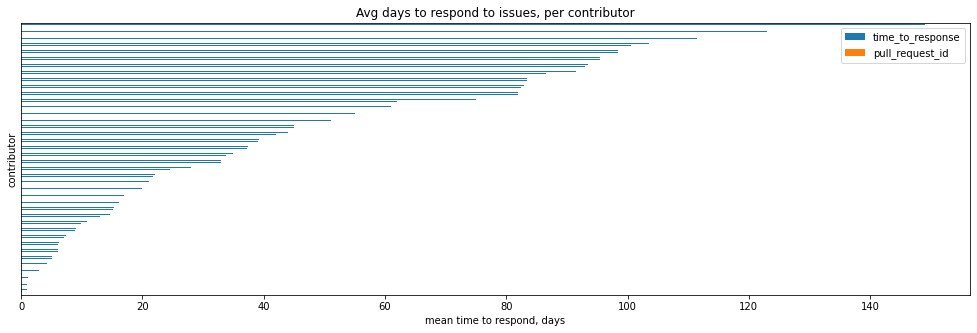

In [8]:
issues_response_df[issues_response_df['time_to_response'] > 0].plot.barh()

plt.xlabel("mean time to respond, days")
plt.ylabel("contributor")
plt.yticks([])
locs, labels = plt.xticks()
plt.title("Avg days to respond to issues, per contributor")
plt.show()

In [9]:
response_df = df_issues[["time_to_response", "msgr_id", "pull_request_id"]]
response_df = response_df[response_df["pull_request_id"].notnull()]
pr_response_df = response_df.groupby("msgr_id").mean().sort_values("time_to_response")
pr_response_df = pr_response_df[["time_to_response"]]

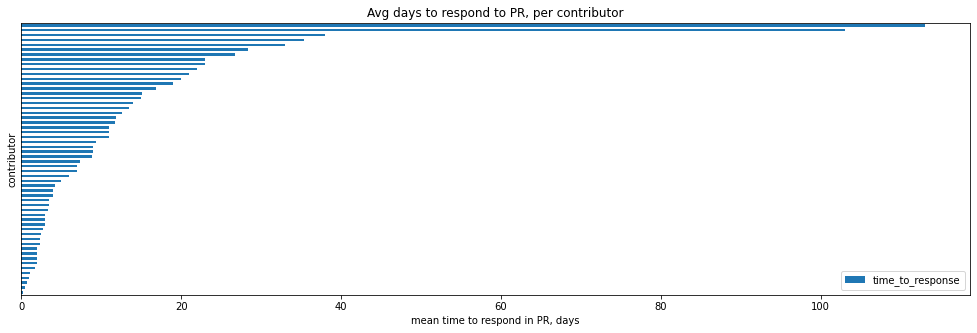

In [10]:
pr_response_df[pr_response_df['time_to_response'] > 0].plot.barh()

plt.xlabel("mean time to respond in PR, days")
plt.yticks([])
plt.ylabel("contributor")
locs, labels = plt.xticks()
plt.title("Avg days to respond to PR, per contributor")
plt.show()

In [11]:
by_issues_opened = df_issues[["reporter_id", "issue_id"]].groupby("reporter_id").count().sort_values("issue_id", ascending=False)

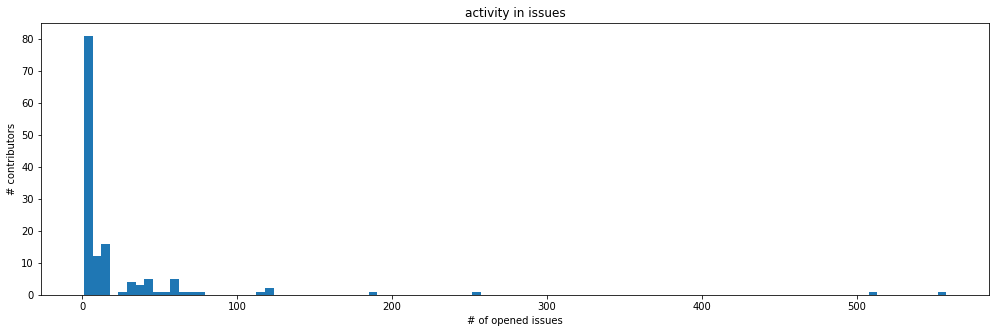

In [12]:
by_issues_opened['issue_id'].plot.hist(bins = 100)

plt.xlabel("# of opened issues")
plt.ylabel("# contributors")
locs, labels = plt.xticks()
plt.title("activity in issues")
plt.show()

In [13]:
by_prs_opened = df_issues[["reporter_id", "pull_request_id"]].groupby("reporter_id").count().sort_values("pull_request_id", ascending=False)

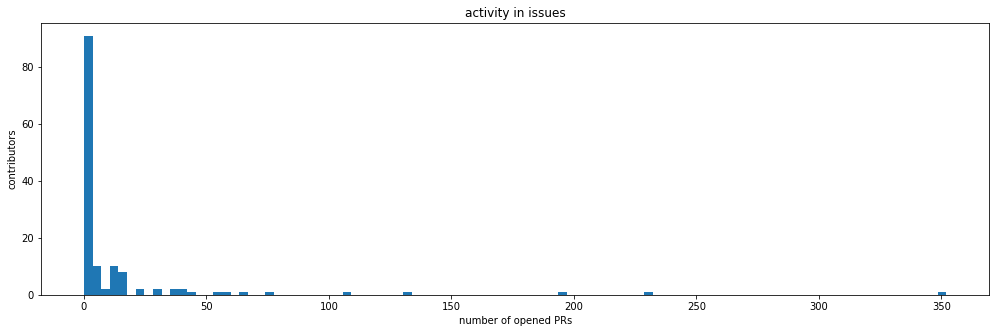

In [14]:
by_prs_opened['pull_request_id'].plot.hist(bins = 100)

plt.xlabel("number of opened PRs")
plt.ylabel("contributors")
locs, labels = plt.xticks()
plt.title("activity in issues")
plt.show()

### By PRs

In [15]:
df_byissue = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    i.reporter_id,
                    i.issue_id AS issue_id, 
                    i.pull_request_id,
                    i.gh_issue_number AS issue_number,
                    i.created_at AS created, 
                    i.closed_at AS closed
                FROM
                    issues i
                 ORDER BY
                    i.created_at                  
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_byissue = pd.concat([df_byissue, df_current_repo])

df_byissue = df_byissue.reset_index()
df_byissue.drop("index", axis=1, inplace=True)

In [16]:
df_byissue = df_byissue.groupby("reporter_id").count().sort_values("pull_request_id", ascending=False)

In [17]:
top_10 = df_byissue.head(10)
not_top_10 = df_byissue.tail(int(len(df_byissue)-10))

In [18]:
top_10['Key'] = '1'
not_top_10['Key'] = '0'

combined_empirical = top_10.append(not_top_10, ignore_index=True)
combined_empirical = combined_empirical.groupby('Key').sum()
combined_empirical

,issue_id,pull_request_id,issue_number,created,closed
Key,,,,,
0,8157,5072,8157,8157,7316
1,4959,3886,4959,4959,4758


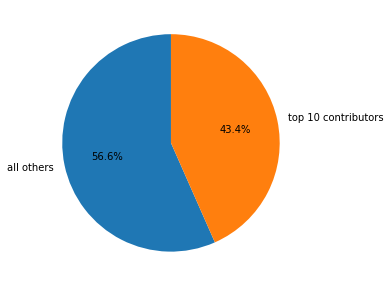

In [19]:
labels = ['all others', 'top 10 contributors']
plt.pie(combined_empirical['pull_request_id'], labels=labels, autopct='%1.1f%%',
        startangle=90)
plt.show()

This next graphic shows the top 10 most active contributors and what percentage of issues they create, as opposed to all other contributors.

In [20]:
lowest_90percent = df_byissue.tail(int(len(df_byissue)*(.9)))
top_10percent = df_byissue.head(int(len(df_byissue)*(.1)))

In [21]:
top_10percent['Key'] = '1'
lowest_90percent['Key'] = '0'

combined = top_10percent.append(lowest_90percent, ignore_index=True)
combined_issue = combined.groupby('Key').sum()
combined_issue

,issue_id,pull_request_id,issue_number,created,closed
Key,,,,,
0,2809,1298,2809,2809,2362
1,10300,7654,10300,10300,9705


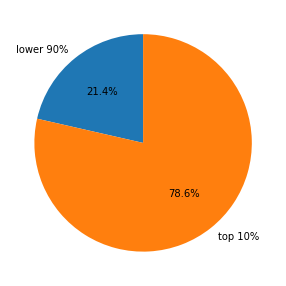

In [22]:
labels = ['lower 90%', 'top 10%']
plt.pie(combined_issue['issue_id'], labels=labels, autopct='%1.1f%%',
        startangle=90)
plt.show()

This next graphic shows the top 10% most active contributors and what percentage of issues they create, as opposed to the lower 90%.

**Drop all duplicate pr_src_id's except for their first occurrence; re-sort in ascending order.**

In [23]:
by_prs = df_byissue[["pull_request_id"]]
by_prs

,pull_request_id
reporter_id,
280529,1116
280837,497
280707,393
280515,341
277145,305
...,...
281351,0
281353,0
281355,0


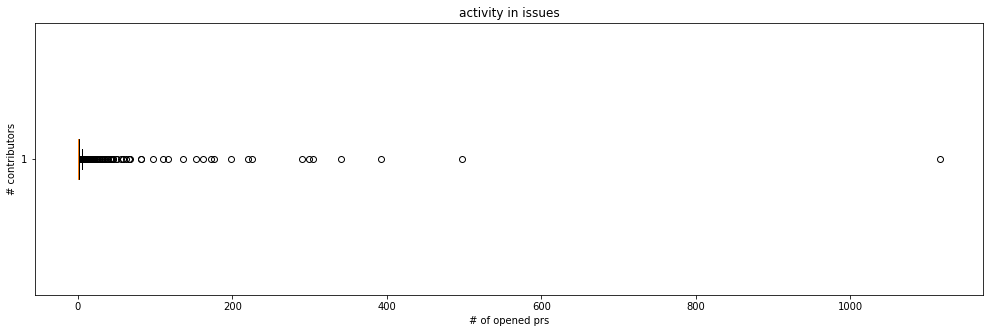

In [24]:
plt.boxplot(df_byissue['pull_request_id'], vert = False)

plt.xlabel("# of opened prs")
plt.ylabel("# contributors")
locs, labels = plt.xticks()
plt.title("activity in issues")
plt.show()